# Method 3 - Good Linear Unbiased Estimator EN 12603

Statistical evaluation of failure stresses. 

The process is as follows:
- Calculate the stress at failure for each specimen and sort them in increasing order of magnitude: $ \sigma_i $, where $ i $ is the rank number.
- Calculate the probability of failure $ P_{f,i} $ for each measured value. Use the following estimator:
$
  P_{f,i} = \frac{i-0.3}{n+0.4}
$
  where $ n $ is the number of tested samples.
- Estimation of the confidence interval for the shape ($\beta$) parameter is given in 8.1. 
- Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.
- Estimation of the confidence intervals of the scale ($\theta$) parameter is given in 8.3.
- The desired confidence intervals for x when G(x) is given is determined numerically by the method in 8.4.1.
- Put the Weibull distribution into linearized form. Enter the measured data into the Weibull mesh.
- Determine the x% fractile value of the bending tensile strength $ f_y $ using the regression line and using the confidence interval.
- Plot the cumulative distribution function $ F(x) $ and the density function $ f(x) $.

In [168]:
{
    "tags": [
        "hide-input",
    ]
}

import numpy as np
import pandas as pd
from scipy.stats import linregress, t, chi2
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

### Input the failure stress rates from experimental data.
1. Enter the $\kappa_{n}$ coefficients based on Table 3 in EN12603 and your data.
2. Select the desired stress fractile and confidence interval.

<p align="center">
  <img src="figures/EN12603-Table-3.png" alt="EN12603-Table-3" style="width:20%; heght:50%">
  <br>
  <i style="italic"> Figure 1: Table 4 from EN12603, where n is the sample size.</i>
</p>

### Definition of useful functions 

In [169]:
{
    "tags": [
        "hide-input",
    ]
}

def calculate_beta_hat(n, kappa_n, stress_rate, s):
  
    # Calculate the sum terms
    sum1 = np.sum(np.log(stress_rate[s:n]))
    sum2 = np.sum(np.log(stress_rate[:s]))

    # Calculate beta
    beta_hat = (n * kappa_n) / ((s / (n - s)) * sum1 - sum2)

    return beta_hat

# Weibull PDF
def weibull_pdf(x, theta, beta):
    return (beta / theta) * (x / theta)**(beta - 1) * np.exp(-(x / theta)**beta)

# Weibull CDF
def weibull_cdf(x, theta, beta):
    return 1 - np.exp(-(x / theta)**beta)

### Estimation of the confidence interval for the shape ($\beta$) parameter is given in 8.1

In [170]:
{
    "tags": [
        "hide-input",
    ]
}

def calculate_beta_hat_theta_hat(n,kappa_n,sorted_stress, s):
    # Point estimators
    beta_hat = calculate_beta_hat(n, kappa_n, sorted_stress, s)
    theta_hat = np.exp((1 / n) * np.sum(np.log(sorted_stress)) + 0.5772 / beta_hat)
    print(f"beta_hat is: {beta_hat:.2f} N/mm2")
    print(f"theta_hat is: {theta_hat:.2f} N/mm2")
    return beta_hat, theta_hat

def confidence_interval_beta(f1,beta_hat, alpha=0.05):

    # Estimation of the confidence interval for the shape parameter is given in 8.1
    # For the 95 % confidence intervals, 1 - α/2 = 0,975 and α/2 = 0,025
    df = f1 # Degrees of freedom based on Table 4
    print(f"Degrees of freedom are: {f1:.2f}")
    alpha = alpha
    chi2_lower_quantile = chi2.ppf(alpha / 2, df)
    chi2_upper_quantile = chi2.ppf(1 - alpha / 2, df)
    print(f"Lower quantile: {chi2_lower_quantile:.6f}")
    print(f"Upper quantile: {chi2_upper_quantile:.2f}")

    # Calculate the upper and lower limits for beta
    beta_lower = (beta_hat * chi2_lower_quantile) / f1
    beta_upper = (beta_hat * chi2_upper_quantile) / f1
    print(f"Beta lower: {beta_lower:.2f}")
    print(f"Beta upper: {beta_upper:.2f}")
    return beta_lower, beta_upper

### Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.

In [171]:
{
    "tags": [
        "hide-input",
    ]
}

def auxiliary_factors(beta_hat,theta_hat, n, r_over_n, stress_or_theta):
    # Auxiliary factor y
    y = beta_hat*np.log(theta_hat/stress_or_theta)
    # Auxiliary factor v
    if r_over_n == 1:
        A = 1.162/n
        B = 0.6482/n + 0.805/n**2 + 1.13/n**3
        C = -0.2309/n + 0.15/n**2 + 1.78/n**3 
        v = A + B*y**2 - 2*C*y
    else:
        raise ValueError("The dataset is censored!")
    # Auxiliary factor gamma
    # Initialize f2 and H_f2 arrays with the same shape as v
    f2 = np.zeros_like(v)
    H_f2 = np.zeros_like(v)
    # Conditions for v <= 2
    condition1 = v <= 2
    f2[condition1] = (8 * v[condition1] + 12) / (v[condition1]**2 + 6 * v[condition1])
    H_f2[condition1] = (15 * f2[condition1]**2 + 5 * f2[condition1] + 6) / (15 * f2[condition1]**3 + 6 * f2[condition1])
    # Conditions for 2 < v <= 5
    condition2 = (v > 2) & (v <= 5)
    f2[condition2] = 3.509 - 1.3055 * v[condition2] + 0.2480 * v[condition2]**2 - 0.0175 * v[condition2]**3
    H_f2[condition2] = 0.08832 + 0.3218 * v[condition2] - 0.0167 * v[condition2]**2
    # Check if any value is outside the acceptable range
    if np.any((v < 0) | (v > 5)):
        raise ValueError("All elements of v must be between 0 and 5")
    gamma_ = np.exp(-y + H_f2)
    return gamma_, f2
# Confindence interval calculation for the P_f or G(x)
def G_ob(beta, theta, stress_or_theta,n, r_over_n, alpha=0.05):
    gamma_, f2 = auxiliary_factors(beta, theta, n, r_over_n, stress_or_theta) 
    df = f2 # Degrees of freedom
    alpha = alpha
    chi2_upper_quantile = chi2.ppf(1 - alpha / 2, df)
    P_f_upper_limit = 1 - np.exp(-gamma_*(chi2_upper_quantile/f2))
    return P_f_upper_limit
def G_un(beta, theta, stress_or_theta,n, r_over_n, alpha=0.05):
    gamma_, f2 = auxiliary_factors(beta, theta, n, r_over_n, stress_or_theta) 
    df = f2 # Degrees of freedom
    alpha = alpha
    chi2_lower_quantile = chi2.ppf(alpha / 2, df)
    P_f_lower_limit = 1 - np.exp(-gamma_*(chi2_lower_quantile/f2))
    return P_f_lower_limit

def confidence_intervals_Gx(beta_hat, theta_hat, n, r_over_n, sorted_stress):

    P_f_upper_limit_list = []
    P_f_lower_limit_list = []

    for stress in sorted_stress:
        P_f_upper_limit_list.append(float(G_ob(beta_hat, theta_hat, stress, n, r_over_n, alpha=0.05)))
        P_f_lower_limit_list.append(float(G_un(beta_hat, theta_hat, stress, n, r_over_n, alpha=0.05)))

    print(f"G(x)_ob upper limit: {P_f_upper_limit_list}")
    print(f"G(x)_un lower limit {P_f_lower_limit_list}")

    return P_f_lower_limit_list, P_f_upper_limit_list

### Estimation of the confidence intervals of the scale ($\theta$) parameter is given in 8.3.

In [172]:
{
    "tags": [
        "hide-input",
    ]
}

def confidence_interval_theta(beta_hat, theta_hat, n, r_over_n):
    theta_ob = theta_hat
    theta_un = theta_hat
    max_iterations = 1000
    tolerance=0.001
    i = 0
    for _ in range(max_iterations):

        new_theta_ob = theta_ob / (np.log(1 / (1 - G_un(beta_hat, theta_hat, theta_ob, n, r_over_n, alpha=0.05)))**(1/beta_hat))
        new_theta_un = theta_un / (np.log(1 / (1 - G_ob(beta_hat, theta_hat, theta_un, n, r_over_n, alpha=0.05)))**(1/beta_hat))
        # Check convergence
        if (abs(new_theta_ob - theta_ob) < tolerance  and
                abs(new_theta_un - theta_un) < tolerance ):
            break
        theta_ob = new_theta_ob
        theta_un = new_theta_un
        print(f"Iteration number {i} | (\u03B8)_ob: {theta_ob:.3f} | (\u03B8)_un: {theta_un:.3f}")
        i += 1

    theta_lower = theta_un
    theta_upper = theta_ob
    return theta_lower, theta_upper

### The desired confidence intervals for x when G(x) is given is determined numerically by the method in 8.4.1.

In [173]:
{
    "tags": [
        "hide-input",
    ]
}

def confidence_interval_stress(beta_hat, theta_hat, n, r_over_n, beta_lower, beta_upper, G_x=0.05, alpha=0.05):
    # Given selected G(x) values
    G_x_values = [0.99, 0.95, 0.80, 0.6321, 0.10, 0.05, 0.02, 0.01]

    # Calculate x values for each G(x)
    x_values = [float(theta_hat * (-np.log(1 - G))**(1/beta_hat)) for G in G_x_values]

    # Print results
    for G, x in zip(G_x_values, x_values):
        print(f"For G(x) = {G:.4f}, \u03C3 = {x:.2f} [N/mm2]")

    P_f_upper_limit_selected_list = []
    P_f_lower_limit_selected_list = []

    for stress in x_values:
        P_f_upper_limit_selected_list.append(float(G_ob(beta_hat, theta_hat, stress, n, r_over_n, alpha=alpha)))
        P_f_lower_limit_selected_list.append(float(G_un(beta_hat, theta_hat, stress, n, r_over_n, alpha=alpha)))
    print("\n")
    print(f"P_f upper limit: {P_f_upper_limit_selected_list}")
    print(f"P_f lower limit {P_f_lower_limit_selected_list}")

    G_x2 = G_x  # Replace with the desired failure probability 
    x2 = float(theta_hat * (np.log(1/(1 - G_x2)))**(1/beta_hat)) 
    print(f"The desired G(x) = {G_x2*100} % probability of failure and the corresponding stress value is x2 = {x2:.2f} [N/mm2]")
    # Find the smallest x in x_values that is greater than x1
    greater_than_G1 = [G for G in G_x_values if G >= G_x2]

    if greater_than_G1:
        nearest_G = min(greater_than_G1)
        index = G_x_values.index(nearest_G)
        x1_hat = x_values[index]
        print(f"The nearest x value greater than {G_x2*100}% is {x1_hat:.2f} [N/mm2] corresponding to G_hat = {nearest_G*100}%")
    else:
        print(f"No x values are greater the set value for x1!")


    G_un_x1 = P_f_lower_limit_selected_list[index]
    G_ob_x1 = P_f_upper_limit_selected_list[index]
    # Calculate x2,ob,z and x2,un,z using the given equations
    x2_ob_z = x1_hat * (np.log(1 - G_x2) / np.log(1 - G_un_x1))**(1/beta_upper)
    x2_un_z = x1_hat * (np.log(1 - G_x2) / np.log(1 - G_ob_x1))**(1/beta_lower)

    print(f"x2: {x2:.2f} [N/mm2]")
    print(f"x2,ob,z: {x2_ob_z:.2f} [N/mm2]")
    print(f"x2,un,z: {x2_un_z:.2f} [N/mm2]")
    
    return x2, x2_ob_z, x2_un_z

### Weibull plot: Graphical representation of the estimated distribution function according to 7.2

In [174]:
{
    "tags": [
        "hide-input",
    ]
}

def weibull_plot(dataset, iteration, Weibull_distribution_parameters, stress_x_percentile, stress_x_percentile_CI_upper, stress_x_percentile_CI_lower, beta_hat, theta_hat, beta_upper, beta_lower, theta_upper, theta_lower, sorted_stress,P_f_lower_limit_list,P_f_upper_limit_list, n, target_G_x=0.05, target_alpha=0.05):
    global min_stress_rate, max_stress_rate  # Declare these as global to modify the outer variables
    # Linearize the Weibull distribution
    ln_stress = np.log(sorted_stress)

    # G(x) values
    G1 = 0.6321
    G2 = 0.01

    # Calculate transformed y-values
    y1 = np.log(np.log(1/(1 - G1)))
    y2 = np.log(np.log(1/(1 - G2)))

    # Calculate x-values in log space
    x1 = np.log(theta_hat)
    x2 = np.log(theta_hat * (0.01005)**(1/beta_hat))

    # Calculate the slope (m)
    slope = (y2 - y1) / (x2 - x1)

    # Equation of the line in the form y = mx + c
    # Use y1 = m * x1 + c to find c
    intercept = y1 - slope * x1
    G_x_line = slope*ln_stress + intercept

     # Calculate x-values in log space
    x1_upper = np.log(theta_upper)
    x2_upper = np.log(theta_upper * (0.01005)**(1/beta_upper))

    # Calculate the slope (m)
    slope_upper = (y2 - y1) / (x2_upper - x1_upper)

    # Equation of the line in the form y = mx + c
    # Use y1 = m * x1 + c to find c
    intercept_upper = y1 - slope_upper * x1_upper
    G_x_line_upper = slope_upper*ln_stress + intercept_upper

         # Calculate x-values in log space
    x1_lower = np.log(theta_lower)
    x2_lower = np.log(theta_lower * (0.01005)**(1/beta_lower))

    # Calculate the slope (m)
    slope_lower = (y2 - y1) / (x2_lower - x1_lower)

    # Equation of the line in the form y = mx + c
    # Use y1 = m * x1 + c to find c
    intercept_lower = y1 - slope_lower * x1_lower
    G_x_line_lower = slope_lower*ln_stress + intercept_lower

    # Median rank estimator for the cumulative probability. 
    G_x = np.array([ (i -0.3)/(n + 0.4) for i in range(1,n+1)])

    ln_ln_G_x = np.log(np.log(1 / (1 - G_x)))
    ln_ln_G_x_ob = np.log(np.log(1 / (1 - np.array(P_f_upper_limit_list))))
    ln_ln_G_x_un = np.log(np.log(1 / (1 - np.array(P_f_lower_limit_list))))
    #slope2, intercept2, r_value, p_value, std_error = linregress(ln_stress, ln_ln_G_x)
    #print(f"r value is {r_value}")

    # Compute mean of observed values
    mean_ln_Pf = np.mean(ln_ln_G_x)

    # Calculate SS_res and SS_tot
    SS_res = np.sum((ln_ln_G_x - G_x_line) ** 2)
    SS_tot = np.sum((ln_ln_G_x - mean_ln_Pf) ** 2)

    # Calculate R^2
    R_squared = 1 - (SS_res / SS_tot)
    print(f"The R^2 value is: {R_squared}")

    print(f"slope is {slope} and intercept is {intercept}")

    scale = theta_hat
    shape = beta_hat
    
    Weibull_distribution_parameters[dataset] = (scale,shape)
    # Determine the 5% fractile
    print(f"{target_G_x*100}% Fractile Stress: {stress_x_percentile:.2f} MPa")
    print(f"{int((1-target_alpha)*100)}% Confidence Interval of 5% Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa")

        # List of marker symbols to cycle through
    # Uncomment more symbols for larger number of datasets
    markers = [
        'o',  # Circle
        'v',  # Triangle down
        '^',  # Triangle up
        's',  # Square
        'D',  # Diamond
        'p',  # Pentagon
        '*',  # Star
        'h',  # Hexagon 1
        'H',  # Hexagon 2
        #'.',  # Point
        #',',  # Pixel
        #'<',  # Triangle left
        #'>',  # Triangle right
        #'1',  # Tri-down
        #'2',  # Tri-up
        #'3',  # Tri-left
        #'4',  # Tri-right
        #'+',  # Plus
        #'x',  # X
        #'d',  # Thin diamond
        #'|',  # Vertical line
        #'_',  # Horizontal line
    ]
    # List of line styles to cycle through
    line_styles = [
        '-',    # Solid line
        '--',   # Dashed line
        '-.',   # Dash-dot line
        ':',    # Dotted line
        # Uncomment more styles for larger number of datasets
        # '',     # No line
    ]

    # List of colors to cycle through
    colors = [
        'b',    # Blue
        'g',    # Green
        'r',    # Red
        'c',    # Cyan
        'm',    # Magenta
        'y',    # Yellow
        'k',    # Black
        # Uncomment more colors for larger number of datasets
        # 'w',   # White
        # '#1f77b4', # Light blue
        # '#ff7f0e', # Orange
        # '#2ca02c', # Light green
        # '#d62728', # Light red
        # '#9467bd', # Purple
    ]
    # Select marker symbol from the list
    marker = markers[iteration % len(markers)]
    # Select line style and color from the lists
    line_style = line_styles[iteration % len(line_styles)]
    color = colors[iteration % len(colors)]
    # Creating a range of x values
    
    if min(sorted_stress) < min_stress_rate:
        print(min_stress_rate)
        min_stress_rate = min(sorted_stress)
    if max(sorted_stress) > max_stress_rate:
        print(max_stress_rate)
        max_stress_rate = max(sorted_stress)

    # Equation of the line in the form y = mx + c
    # Use y1 = m * x1 + c to find c
    x = np.linspace(min_stress_rate-30,max_stress_rate+30,1000)
    y = weibull_cdf(x, scale, shape)
    #fitted_line = np.log(np.log(1 / (1 - (slope * x + intercept)))) 
    #slope, intercept, r_value, p_value, std_error = linregress(np.log(stress_rate), np.log(P_f))
    #plt.fill_between(sorted_stress, np.exp(slope * ln_stress + intercept - C), np.exp(slope * ln_stress + intercept + C), color='grey', alpha=0.3, label=f'{int((1-target_alpha/2)*100)}% Confidence interval')
    if display_confidence_intervals_ON:
        y_lower = weibull_cdf(x, theta_lower, beta_lower)
        y_upper = weibull_cdf(x, theta_upper, beta_upper)
        plt.fill_between(x, y_upper, y_lower, color='grey', alpha=0.3, label=f'{int((1-target_alpha)*100)}% Confidence interval')
    plt.scatter(sorted_stress, G_x, color= color, s=6, label=f'{dataset}; \u03BB={shape:.2f} & \u03B2={scale:.2f}',marker = marker)
    plt.plot(x, y, color=color)

    # plt.fill_between(ln_stress, ln_ln_G_x_un, ln_ln_G_x_ob, color='grey', alpha=0.3, label='Confidence interval')
    # plt.plot(ln_stress, ln_ln_G_x, marker, label=f'{dataset}; \u03B2={shape:.2f} & \u03B8={scale:.2f}')
    # plt.plot(ln_stress, G_x_line, 'r')

    # Add regression equation and R-squared below the figure
    regression_text = f"y = {slope:.2f}x {'+' if intercept > 0 else '-'} {abs(intercept):.2f}; $R^2$ = {R_squared:.3f}"
    stress_text = f"{target_G_x*100}% Fractile Stress: {stress_x_percentile:.2f} MPa\n" \
                  f"{int((1-target_alpha)*100)}% Confidence Interval of {target_G_x*100}% Fractile: ({stress_x_percentile_CI_lower:.2f}, {stress_x_percentile_CI_upper:.2f}) MPa"
    plt.figtext(0.5, -0.11 - iteration * 0.11,
        f"Regression line for {dataset}: {regression_text}\n {stress_text}",
        wrap=True, horizontalalignment='center', fontsize=10,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
    


### Input the failure stress rates from experimental data.
1. Enter the $\kappa_{n}$ coefficients based on Table 3 in EN12603 and your data.
2. Select the desired stress fractile and confidence interval.

<p align="center">
  <img src="figures/EN12603-Table-3.png" alt="EN12603-Table-3" style="width:20%; heght:50%">
  <br>
  <i style="italic"> Figure 1: Table 4 from EN12603, where n is the sample size.</i>
</p>

In [175]:
{
    "tags": [
        "hide-input",
    ]
}

# Create an HTML widget for instructions
instructions = widgets.HTML(
    value="""
    <p style="font-size: 16px">Enter the data separated by commas, with decimal point (e.g. "1.44, 2.33, 4.22, 3.01,...")</p>
    <b style="font-size: 16px">Data protection declaration: The data entered will not be saved or transmitted over the network.</b>
    """
)

blank_space = widgets.HTML(
    value="""<br>"""
)


# Create multiple text input widgets
text_input1 = widgets.Text(
    description="Dataset 1:",
    placeholder="57.0571, 53.1429, 57.2857, 58.3429, 58.6286, 62.8000, 67.7143, 68.8857, 76.3429, 76.4571, 77.4571, 79.0000, 82.1714, 87.5429",
    value = "57.0571, 53.1429, 57.2857, 58.3429, 58.6286, 62.8000, 67.7143, 68.8857, 76.3429, 76.4571, 77.4571, 79.0000, 82.1714, 87.5429",
    layout = widgets.Layout(width='700px')
)

text_input2 = widgets.Text(
    description="Dataset 2:",
    placeholder="41.26, 42.54, 44.31,44.43,44.67,45.02, 45.37,46.08, 46.08, 46.55,47.86,48.21,48.21,48.31, 49.63,50.34, 50.43, 50.69,50.78, 51.05, 51.05,51.05,51.76, 53.17",
    value = "41.26, 42.54, 44.31,44.43,44.67,45.02, 45.37,46.08, 46.08, 46.55,47.86,48.21,48.21,48.31, 49.63,50.34, 50.43, 50.69,50.78, 51.05, 51.05,51.05,51.76, 53.17",
    layout = widgets.Layout(width='700px')
)

text_input3 = widgets.Text(
    description="Dataset 3:",
    placeholder="84.1,95.4,112.4,101.4,112.4,118.3,126.3,128.3,129.3,147,160.8,167.1,171,175,176,183,188.9,190.9,192.9,193.9,194.9,195.9,196.9,198.9,198.9,203.9,205.9,208,208.8,210.8,224.7,253.6",
    value = "84.1,95.4,112.4,101.4,112.4,118.3,126.3,128.3,129.3,147,160.8,167.1,171,175,176,183,188.9,190.9,192.9,193.9,194.9,195.9,196.9,198.9,198.9,203.9,205.9,208,208.8,210.8,224.7,253.6",
    layout = widgets.Layout(width='700px')
)

# Create multiple text input widgets
text_input4 = widgets.Text(
    description=f"\u03BA_n1:",
    placeholder="1.3686",
    value = "1.3686"
)

text_input5 = widgets.Text(
    description=f"\u03BA_n2:",
    placeholder="1.4975",
    value = "1.4975"
)

text_input6 = widgets.Text(
    description=f"\u03BA_n3:",
    placeholder="1.4665",
    value = "1.4665"
)

text_input7 = widgets.Text(
    description="Target stress fractile:   ",
    placeholder="0.05",
    value = "0.05",
    style={'description_width': '200px'},
    layout = widgets.Layout(width='270px')
)

text_input8 = widgets.Text(
    description="Target confidence interval:",
    placeholder="0.05",
    value = "0.05",
    style={'description_width': '200px'},
    layout = widgets.Layout(width='270px')
)

# Create a submit button
submit_button = widgets.Button(
    description='Evaluate'
)

# Create a container to display output
output = widgets.Output()

# Dictionary to hold datasets: Default values
stress_rates = {
    "dataset-1": np.array([57.0571, 53.1429, 57.2857, 58.3429, 58.6286, 62.8000, 67.7143, 68.8857, 76.3429, 76.4571, 77.4571, 79.0000, 82.1714, 87.5429]),
    "dataset-2": np.array([41.26, 42.54, 44.31,44.43,44.67,45.02, 45.37,46.08, 46.08, 46.55,47.86,48.21,48.21,48.31, 49.63,50.34, 50.43, 50.69,50.78, 51.05, 51.05,51.05,51.76, 53.17]),
    "dataset-3": np.array([84.1,95.4,112.4,101.4,112.4,118.3,126.3,128.3,129.3,147,160.8,167.1,171,175,176,183,188.9,190.9,192.9,193.9,194.9,195.9,196.9,198.9,198.9,203.9,205.9,208,208.8,210.8,224.7,253.6]),
}
kappa_ns = {
    "dataset-1": 1.3686,
    "dataset-2": 1.4975,
    "dataset-3": 1.4665,
}
# Default values:
target_G_x = 0.001 # Target stress fractile
target_alpha = 0.05 # Target confidence interval 

# Define what happens when the button is clicked
def on_submit_button_clicked(b):
    global target_G_x, target_alpha  # Declare these as global to modify the outer variables
    with output:
        clear_output()
        input1 = text_input1.value
        input2 = text_input2.value
        input3 = text_input3.value
        input4 = text_input4.value
        input5 = text_input5.value
        input6 = text_input6.value
        input7 = text_input7.value
        input8 = text_input8.value
        # Process or display the inputs as needed
        try:
            # Convert the input string to a list of numbers
            stress_rates['dataset-1'] = [float(x) for x in input1.split(",")]
            stress_rates['dataset-2'] = [float(x) for x in input2.split(",")]
            stress_rates['dataset-3'] = [float(x) for x in input3.split(",")]
            kappa_ns['dataset-1'] = float(input4)
            kappa_ns['dataset-2'] = float(input5)
            kappa_ns['dataset-3'] = float(input6)
            target_G_x = float(input7)
            target_alpha = float(input8)
            print(f"Dataset 1: {stress_rates['dataset-1']}")
            print(f"Dataset 2: {stress_rates['dataset-2']}")
            print(f"Dataset 3: {stress_rates['dataset-3']}")
            print(f"\u03BA_n1: {kappa_ns['dataset-1']}; n = {len(stress_rates['dataset-1'])} samples")
            print(f"\u03BA_n2: {kappa_ns['dataset-2']}; n = {len(stress_rates['dataset-2'])} samples")
            print(f"\u03BA_n3: {kappa_ns['dataset-3']}; n = {len(stress_rates['dataset-3'])} samples")
            print(f"Target stress fractile: {target_G_x*100}%")
            print(f"Target confidence interval: {int((1-target_alpha)*100)}%")
        except ValueError:
            print("Please enter valid comma-separated numbers or valid numbers.")

# Attach the onclick event to the button
submit_button.on_click(on_submit_button_clicked)

# Display the widgets
container1 = widgets.VBox([text_input1, text_input2, text_input3])
container2 = widgets.VBox([text_input4, text_input5, text_input6])
container3 = widgets.VBox([text_input7, text_input8])
display(instructions, container1, container2,blank_space,container3, submit_button, output)
#display(text_input1, text_input2, text_input3, submit_button, output)

HTML(value='\n    <p style="font-size: 16px">Enter the data separated by commas, with decimal point (e.g. "1.4…

HTML(value='<br>')

Button(description='Evaluate', style=ButtonStyle())

Output()

In [176]:
display_confidence_intervals_ON = False # Turn the confidence intervals ON/OFF in the Logarithmic CDF Weibull Plot

## Statistical evaluation: Uncensored sample

##############################################################
#  Statistical evalution for dataset-1 according to EN12603  #
##############################################################
[57.0571 53.1429 57.2857 58.3429 58.6286 62.8    67.7143 68.8857 76.3429
 76.4571 77.4571 79.     82.1714 87.5429]
Estimation of the confidence interval for the shape β parameter is given in 8.1
___________________________________________________________________________________


beta_hat is: 6.91 N/mm2
theta_hat is: 73.87 N/mm2
Degrees of freedom are: 39.35
Lower quantile: 23.926554
Upper quantile: 58.55
Beta lower: 4.20
Beta upper: 10.28


Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.
__________________________________________________________________________________________________________________________


G(x)_ob upper limit: [0.26032523175500333, 0.34804565953236277, 0.3535707051508711, 0.37965474245785835, 0.386849631

Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,36.75,23.94,48.36
5%,48.06,35.49,57.26
50%,70.05,59.74,75.59
Selected 0.1%,27.19,14.58,39.49


##############################################################
#  Statistical evalution for dataset-2 according to EN12603  #
##############################################################
[41.26 42.54 44.31 44.43 44.67 45.02 45.37 46.08 46.08 46.55 47.86 48.21
 48.21 48.31 49.63 50.34 50.43 50.69 50.78 51.05 51.05 51.05 51.76 53.17]
Estimation of the confidence interval for the shape β parameter is given in 8.1
___________________________________________________________________________________


beta_hat is: 18.68 N/mm2
theta_hat is: 49.26 N/mm2
Degrees of freedom are: 70.20
Lower quantile: 48.924389
Upper quantile: 95.26
Beta lower: 13.02
Beta upper: 25.35


Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.
__________________________________________________________________________________________________________________________


G(x)_ob upper limit: [0.10217423363713107, 0.15420618043131362, 0.2597333347364144

Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,38.05,34.08,41.27
5%,42.02,38.9,44.27
50%,48.31,46.42,49.43
Selected 0.1%,34.04,29.05,38.02


##############################################################
#  Statistical evalution for dataset-3 according to EN12603  #
##############################################################
[ 84.1  95.4 112.4 101.4 112.4 118.3 126.3 128.3 129.3 147.  160.8 167.1
 171.  175.  176.  183.  188.9 190.9 192.9 193.9 194.9 195.9 196.9 198.9
 198.9 203.9 205.9 208.  208.8 210.8 224.7 253.6]
Estimation of the confidence interval for the shape β parameter is given in 8.1
___________________________________________________________________________________


beta_hat is: 5.22 N/mm2
theta_hat is: 183.90 N/mm2
Degrees of freedom are: 94.88
Lower quantile: 69.821963
Upper quantile: 123.72
Beta lower: 3.84
Beta upper: 6.81


Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.
__________________________________________________________________________________________________________________________


G(x)_ob upper limit: [0.0496854445

Fractile [%],Stress [MPa],95% CI lower [MPa],95% CI upper [MPa]
0.8%,73.02,52.5,94.37
5%,104.14,82.69,122.83
50%,171.43,152.37,184.54
Selected 0.1%,49.01,30.54,69.51


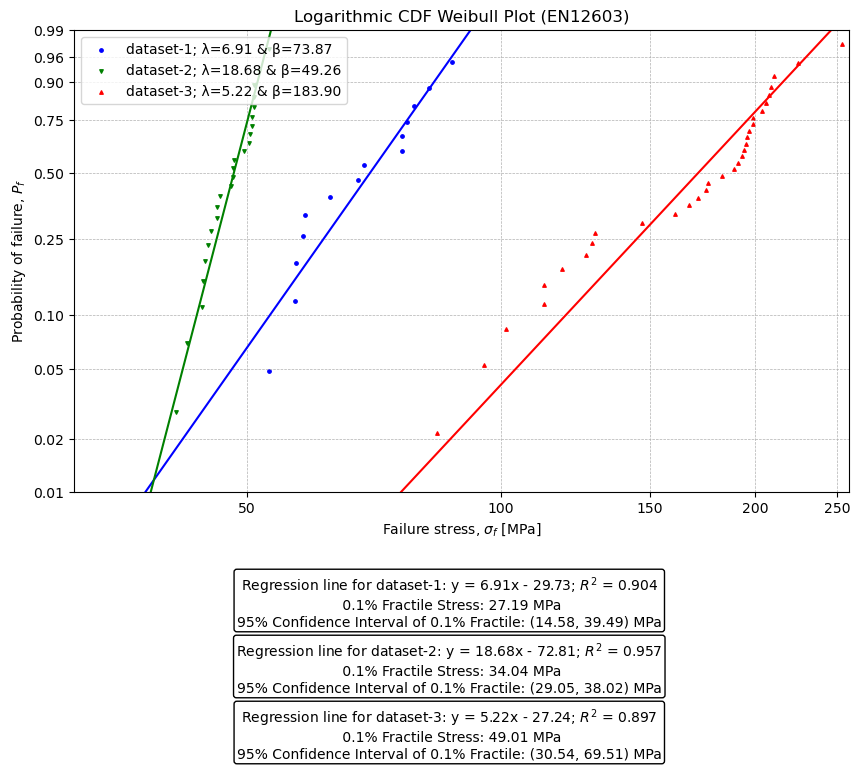

In [177]:
plt.figure(figsize=(10, 6))
iteration = 0; 
min_stress_rate = 100000
max_stress_rate = -10000
# Initialize an empty dictionary to store the scale & shape value of a Weibull distribution corresponding to each dataset.
Weibull_distribution_parameters = {}
for dataset, stress_rate in stress_rates.items():
    print(f"##############################################################")
    print(f"#  Statistical evalution for {dataset} according to EN12603  #")
    print(f"##############################################################")
    print(stress_rate)
    # Sort the stress in increasing order
    sorted_stress = np.sort(stress_rate)

    # Calculate probability of failure (P_f,i)
    n = len(sorted_stress)
    kappa_n = kappa_ns[dataset] # From Table 3

    s = int(np.floor(0.84*n))
    r = n
    r_over_n = r/n

    if r_over_n == 1:
        f1 = n*(3.085 - 3.84/n) # In case of uncensored samples
        # Or use linear interpolation
    # else:
    # # Implement the f1 value in case of censored samples r/n < 1

    print("Estimation of the confidence interval for the shape \u03B2 parameter is given in 8.1")
    print(f"___________________________________________________________________________________")
    print("\n")
    beta_hat, theta_hat = calculate_beta_hat_theta_hat(n,kappa_n,sorted_stress, s)
    beta_lower, beta_upper = confidence_interval_beta(f1,beta_hat, alpha=target_alpha)
    print("\n")

    print("Estimation of the confidence intervals for G(x) is given in 8.2 and the results of the computations are given in Table A.2.")
    print(f"__________________________________________________________________________________________________________________________")
    print("\n")
    P_f_lower_limit_list, P_f_upper_limit_list = confidence_intervals_Gx(beta_hat, theta_hat, n, r_over_n, sorted_stress)
    print("\n")

    print("Estimation of the confidence intervals of the scale \u03B8 parameter is given in 8.3.")
    print(f"____________________________________________________________________________________")
    print("\n")
    theta_lower, theta_upper = confidence_interval_theta(beta_hat, theta_hat, n, r_over_n)
    print("\n")

    print("The confidence intervals for x when G(x) is given is determined numerically by the method in 8.4.1.")
    print(f"_______________________________________________________________________________________________________")
    print("\n")
    x2,x2_ob_z, x2_un_z = confidence_interval_stress(beta_hat, theta_hat, n, r_over_n, beta_lower, beta_upper, G_x=target_G_x, alpha=target_alpha)
    print("\n")

    stress_x_percentile, stress_x_percentile_CI_upper, stress_x_percentile_CI_lower = round(x2,2),round(x2_ob_z,2), round(x2_un_z,2)
    # Weibull plot
    weibull_plot(dataset,
                 iteration,
                 Weibull_distribution_parameters, 
                 stress_x_percentile, 
                 stress_x_percentile_CI_upper,
                 stress_x_percentile_CI_lower,
                 beta_hat, 
                 theta_hat,
                 beta_upper,
                 beta_lower,
                 theta_upper,
                 theta_lower, 
                 sorted_stress,
                 P_f_lower_limit_list,
                 P_f_upper_limit_list, 
                 n,
                 target_G_x=target_G_x, 
                 target_alpha=target_alpha)
    iteration += 1
    print("\n")

    # Determine the 0.8% fractile
    G_x_08 = 0.008
    x_08,x_08_ob_z, x_08_un_z = confidence_interval_stress(beta_hat, theta_hat, n, r_over_n, beta_lower, beta_upper, G_x=G_x_08, alpha=target_alpha)
    stress_08_percentile, stress_08_percentile_CI_upper, stress_08_percentile_CI_lower = round(x_08,2), round(x_08_ob_z,2), round(x_08_un_z,2)

    # Determine the 5% fractile
    G_x_5 = 0.05
    x_5,x_5_ob_z, x_5_un_z = confidence_interval_stress(beta_hat, theta_hat, n, r_over_n, beta_lower, beta_upper, G_x=G_x_5, alpha=target_alpha)
    stress_5_percentile, stress_5_percentile_CI_upper, stress_5_percentile_CI_lower = round(x_5,2), round(x_5_ob_z,2), round(x_5_un_z,2)
    # Determine the 50% fractile
    G_x_50 = 0.5
    x_50,x_50_ob_z, x_50_un_z = confidence_interval_stress(beta_hat, theta_hat, n, r_over_n, beta_lower, beta_upper, G_x=G_x_50, alpha=target_alpha)
    stress_50_percentile, stress_50_percentile_CI_upper, stress_50_percentile_CI_lower = round(x_50,2), round(x_50_ob_z,2), round(x_50_un_z,2)

    # Define the data for the table containing integers
    table_data = [
        ("Fractile [%]", "Stress [MPa]", "95% CI lower [MPa]", "95% CI upper [MPa]"),
        ("0.8%", stress_08_percentile, stress_08_percentile_CI_lower, stress_08_percentile_CI_upper),  # Row 1 
        ("5%", stress_5_percentile,stress_5_percentile_CI_lower,stress_5_percentile_CI_upper),         # Row 2 
        ("50%", stress_50_percentile,stress_50_percentile_CI_lower,stress_50_percentile_CI_upper),      # Row 3 
        (f"Selected {target_G_x*100}%", stress_x_percentile,stress_x_percentile_CI_lower,stress_x_percentile_CI_upper)      # Row 3 
    ]

    # Generate HTML for the table
    html_content = f"""
    <table border='1' style='border-collapse: collapse;'>
        <caption style='caption-side: top; font-weight: bold;'>{dataset}</caption>
    """
    for row in table_data:
        html_content += "<tr>"
        for item in row:
            html_content += f"<td style='padding: 5px;'>{item}</td>"
        html_content += "</tr>"
    html_content += "</table>"

    # Display the table using HTML
    display(HTML(html_content))

plt.xlabel(f'Failure stress, $\u03C3_f$ [MPa]')
plt.ylabel('Probability of failure, $P_f$')
plt.title('Logarithmic CDF Weibull Plot (EN12603)')

probs = [0.01, 0.02, 0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.96, 0.99]
num_ticks = 5  # Define how many intervals you want
xticks = np.linspace(20, max_stress_rate, num_ticks).astype(int)
display_xticks = [ 20, 30, 45, 60, 100, 150, 200]

# Set custom y-ticks and log scale
SMALL = 1.0e-20    # attempt to protect against invalid arguments to log
def forwardY( p ):
    return np.log(np.fmax(SMALL, -np.log(np.fmax(SMALL,1-p))))

def inverseY( q ):
    return 1 - np.exp(-np.exp(q))

def forwardX(x):
    return np.log(np.fmax(SMALL,x))

def inverseX(y):
    return np.exp(y)


# Set the minor ticks for grid lines
plt.minorticks_on()
plt.gca().set_xticks(xticks, minor=True)
plt.xticks(display_xticks)
#x = np.linspace(min_stress_rate-30,max_stress_rate+30,1000)
plt.xlim(left=min_stress_rate-10, right=max_stress_rate+5)
plt.ylim(bottom=0.01, top=0.99)
plt.xscale('function', functions=(forwardX,inverseX))
plt.yscale('function', functions=(forwardY,inverseY))
plt.yticks(probs)

# Get handles and labels, then filter to make them unique
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels_set = set()
unique_handles_labels = []

for handle, label in zip(handles, labels):
    if label not in unique_labels_set:
        unique_handles_labels.append((handle, label))
        unique_labels_set.add(label)

# Construct separate lists for handles and labels, and position the legend
if unique_handles_labels:
    unique_handles, unique_labels = zip(*unique_handles_labels)
    plt.legend(unique_handles, unique_labels, loc='upper left')
#plt.grid(True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


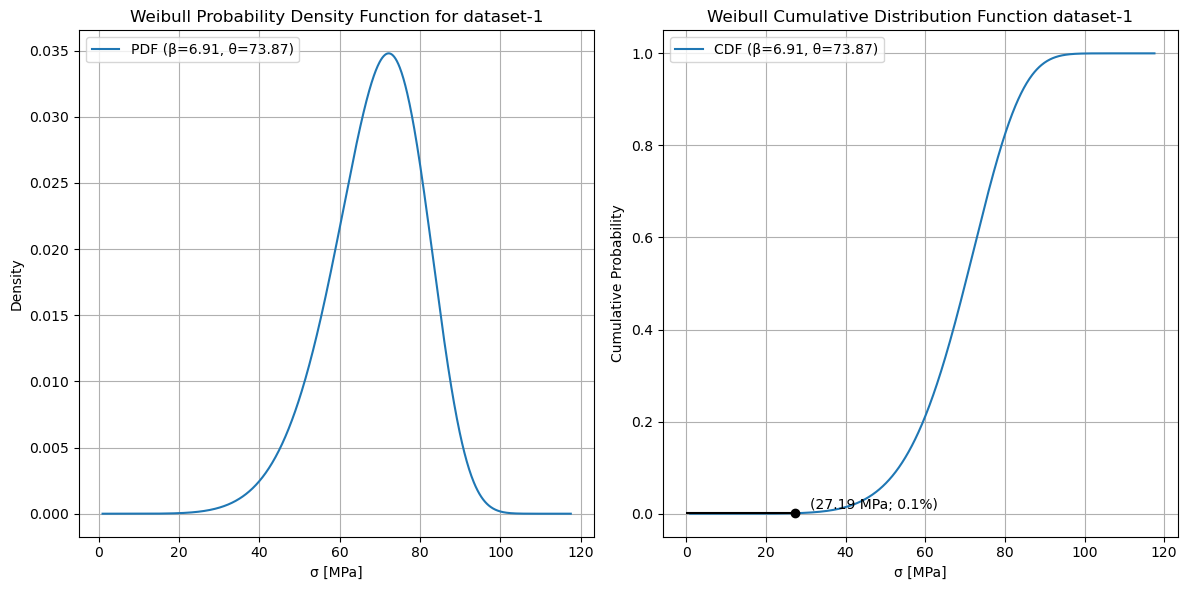

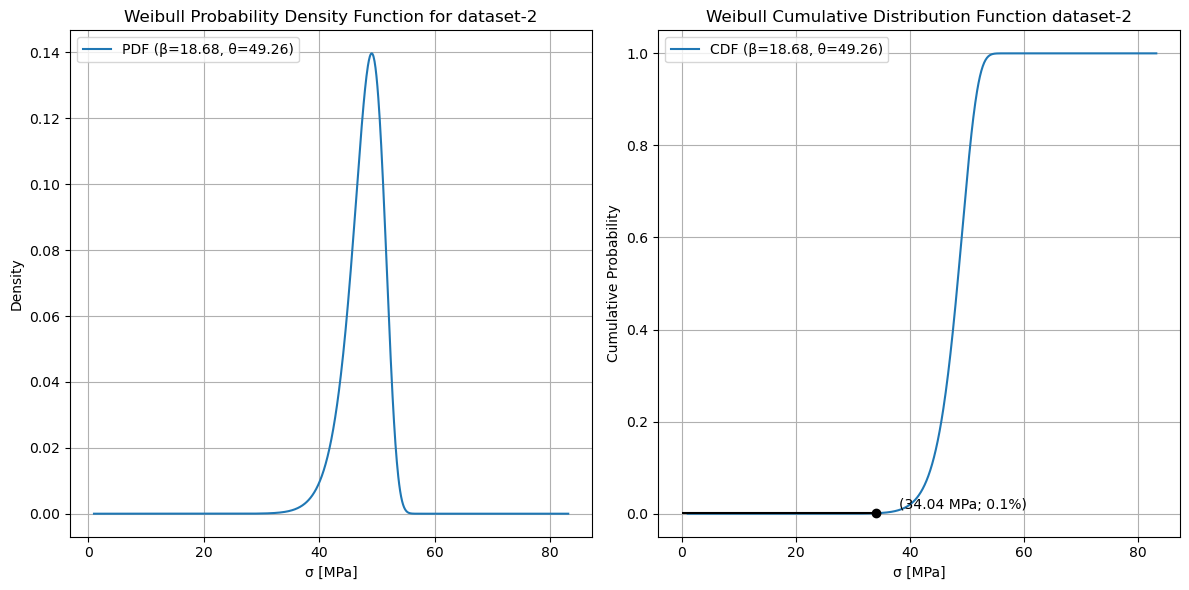

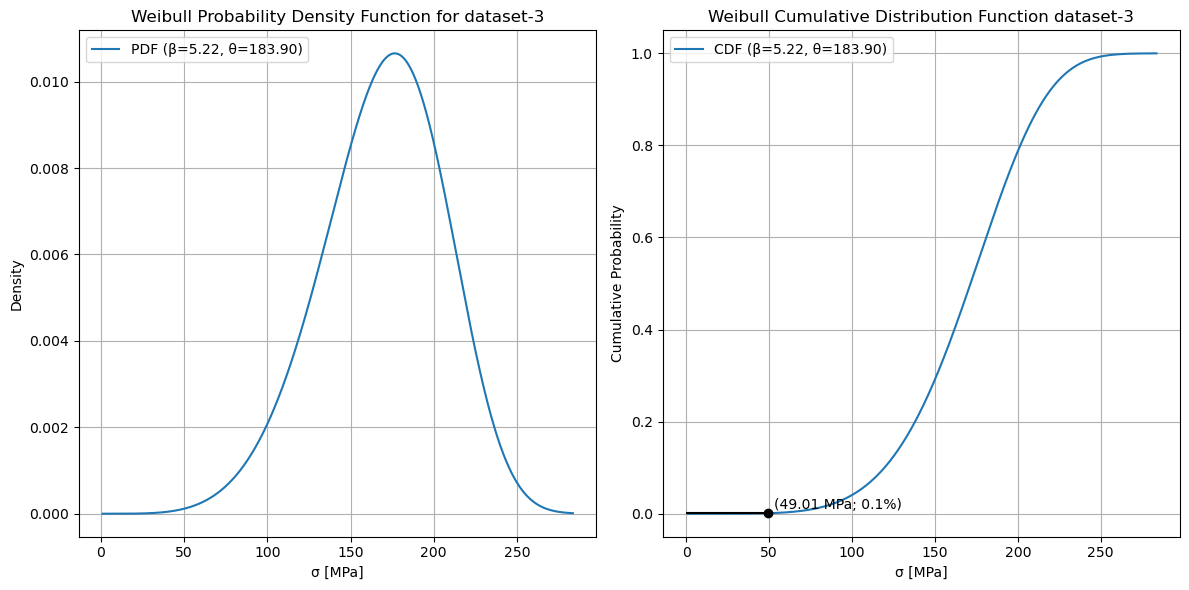

In [178]:
for dataset, stress_rate in stress_rates.items():
    # Creating a range of x values
        x = np.linspace(1,max(stress_rate)+30,1000)
        # Calculate PDF and CDF
        pdf_values = weibull_pdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
        cdf_values = weibull_cdf(x, Weibull_distribution_parameters[dataset][0], Weibull_distribution_parameters[dataset][1])
        # Calculate the x% fractile
        target_percentile = 1 - target_G_x
        x_percentile = Weibull_distribution_parameters[dataset][0] * (-np.log(target_percentile))**(1/Weibull_distribution_parameters[dataset][1])
        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot PDF
        plt.subplot(1, 2, 1)
        plt.plot(x, pdf_values, label=f"PDF (\u03B2={Weibull_distribution_parameters[dataset][1]:.2f}, \u03B8={Weibull_distribution_parameters[dataset][0]:.2f})")
        plt.title(f'Weibull Probability Density Function for {dataset}')
        plt.xlabel('\u03C3 [MPa]')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend(loc='upper left')
        # Plot CDF
        plt.subplot(1, 2, 2)
        plt.plot(x, cdf_values, label=f"CDF (\u03B2={Weibull_distribution_parameters[dataset][1]:.2f}, \u03B8={Weibull_distribution_parameters[dataset][0]:.2f})")
        plt.hlines(target_G_x, 0, x_percentile, color='black', linestyle='-')
        plt.vlines(x_percentile, 0, target_G_x, color='black', linestyle='-')
        # Add a circular marker at the 5% fractile
        plt.scatter([x_percentile], [target_G_x], color='black', zorder=5)
        # Annotate the 5% fractile
        plt.text(x_percentile + 4, target_G_x + 0.01, f'({x_percentile:.2f} MPa; {target_G_x*100}%)', fontsize=10)
        plt.title(f'Weibull Cumulative Distribution Function {dataset}')
        plt.xlabel('\u03C3 [MPa]')
        plt.ylabel('Cumulative Probability')
        
        plt.grid(True)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
    